# Model Analysis
## An assessment of Sea Surface Salinity(SSS) CeNCOOS(nowcast), RTOFS(forecast), observed and climatological data in the Monterey Bay Area.
### This notebook presents an analysis of CeNCOOS and RTOFS predictions for a location where we have observed and climatological SSS recorded.
### First, we load necessary packages and function. We prompt user date input for both models and observed data. Climatological data should be downloaded to computer beforehand. Data sources specified. We have necessary functions for data extraction.
### Second, we fetch and process RTOFS (netCDF format) and CeNCOOS (netCDF format), from an online server and processed using the xarray package. We fetch both Observed and Climatological data. We group data by day and month. For RTOFS we also sort by lead day.
### Third, we merge all 4 data sets and produce summary statistics and plot.


In [1]:
from typing import Tuple, Dict, List

import numpy as np
import xarray as xr
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
import glob
import sys

sys.path.append(os.path.relpath('../src'))

from model_analysis import sum_1_column
from model_analysis import in_bounds
from model_analysis import sum_cmatrix
from model_analysis import pairwise_comparison

In [2]:
#user input for forecast, nowcast and observed dates

# format of lists [year,month,day]

#RTOFS
min_date_RTOFS = [2021,12,15] #today's date
max_date_RTOFS = [2021,11,20] #lead date ahead
LeadDay = 1 #specify desired lead day

#Nowcast
min_date_CeNCOOS = [2021,8,1] #initial nowcast date desired
max_date_CeNCOOS = [2021,12,16] #tomorrows date

#Observed
min_date_Observed = [2021, 8, 1] #initial nowcast date desired
max_date_Observed = [2021, 12, 16] #tomorrows date

#need folder specifications

In [3]:
#data sources

sources = ["RTOFS","CeNCOOS","Observed"]

sourcesabbv = ["R","C","O"]

models = ["RTOFS","CeNCOOS"]

modelabbv = ["R","C"]

var_name = {'count':0,'tally':0,'total':0,'summ':0,'count3':0,'tally3':0,'count2':0,'tally2':0,'total2':0,'summ2':0}

name = list(var_name.keys())

In [4]:
#functions for model extraction

def pad_with_zeros(x: int) -> str:
    return str(x) if x > 9 else '0' + str(x)

def create_date_string(date: Tuple[int, int, int]) -> str:
    return str(date[0]) + '-' + pad_with_zeros(date[1]) + '-' + pad_with_zeros(date[2])

def convert_time_tuple_to_str(x: Tuple[int, int, int]):
    """
    Converts a YYYY-MM-DD date, provided as a tuple, into a string

    :param x: tuple with year, month, day as integers
    :return: date string: YYYY-MM-DD, len=8, with 0s padding MM and DD as needed
    """
    return str(x[0]) + '-' + pad_with_zeros(x[1]) + '-' + pad_with_zeros(x[2])


def convert_str_to_date(date_string: str) -> np.datetime64:
    return np.datetime64(date_string)

def extract_data_from_nc(nc_folder: str, ocean_var: str) -> pd.DataFrame:
    """
    Read netCDF file from disk and extract data from one ocean variable
    :param nc_folder: location of 'cencoos.nc' file
    :param ocean_var: one of 'sst' (sea surface temperature),
                             'sss' (sea surface salinity),
                             'u' (surface zonal current speed),
                             'v' (surface meridional current speed)
                             'zeta'(sea surface height)
    """
    if not ocean_var in ['sst', 'sss', 'u', 'v', 'zeta']:
        raise Exception('Variable not in file')
    b = xr.open_dataset(nc_folder + 'cencoos.nc')
    df = pd.DataFrame({'time': np.array(b['time']),
                      ocean_var: np.array([x[0][0] for x in b[ocean_var]])})
    return df

In [5]:
#downloading functions for RTOFS data

def get_rtofs2d(
        lon: float,
        lat: float,
        min_date: Tuple[int, int, int],
        max_date: Tuple[int, int, int],
        output_folder: str,
        use_si_units: str
) -> str:
    """
    Download RTOFS surface nowcast and forecast from ERDDAP

    :param min_lon: lower value of longitude for AOI bounding box
    :param max_lon: upper value of longitude for AOI bounding box
    :param min_lat: lower value of latitude for AOI bounding box
    :param max_lat: upper value of latitude for AOI bounding box
    :param min_date: current date (tuple with year, month, day)
    :param max_date: last day of forecast (tuple with year, month, day)
    :param output_folder: name of folder where downloaded netCDF file is stored
    :param use_si_units: keep original SI units?
    :return: path to new netCDF file created in device that holds the data
    """

    # Creating URL
    rtofs2d = {
        "dataset_id": "ncepRtofsG2DFore3hrlyProg_LonPM180",
        "environmental_variable": ["sst", "sss", "u_velocity", "v_velocity"]
    }
    #if lon < 74.16:
    #    lon += 360
    min_time = convert_time_tuple_to_str(min_date) + 'T00:00:00Z'
    max_time = convert_time_tuple_to_str(max_date) + 'T23:59:59Z'
    head = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/'
    body = (
            '[(' + min_time + '):1:(' + max_time + ')]' +
            '[(1.0):1:(1.0)]' +
            '[(' + str(lat) + '):1:(' + str(lat) + ')]' +
            '[(' + str(lon) + '):1:(' + str(lon) + ')]'
    )
    tail = ','.join([e + body for e in rtofs2d['environmental_variable']])
    url = head + rtofs2d['dataset_id'] + '.nc?' + tail

    # Fetching file
    #print(url)
    r = requests.get(url=url, allow_redirects=True)

    # Storing file
    out_file = output_folder + 'rtofs2d' + min_time +'.nc'
    tmp_file = output_folder + 'tmp.nc'
    open(tmp_file, 'wb').write(r.content)
    try:
        ds = xr.open_dataset(tmp_file)
    except Exception:
        print('RTOFS not available')
    else:
        if use_si_units == 'F':
            ds['sst'] = ((ds['sst'] * 9/5) + 32).assign_attrs({'units': 'F'})
            ds['u_velocity'] = (ds['u_velocity'] * 1.94384).assign_attrs({'units': 'knots'})
            ds['v_velocity'] = (ds['v_velocity'] * 1.94384).assign_attrs({'units': 'knots'})
        ds.to_netcdf(out_file)
    os.remove(tmp_file)

    return out_file


def extract_data_from_rtofs_nc(lon: float, lat: float, out_file: str, ocean_var: str) -> pd.DataFrame:
    """
    Read netCDF file from disk and extract data from one ocean variable
    :param lon: longitude of desired point
    :param lat: latitude of desired point
    :param nc_folder: location of 'rtofs2d.nc' file
    :param ocean_var: one of 'sst' (sea surface temperature),
                             'sss' (sea surface salinity),
                             'u_velocity' (surface zonal current speed),
                             'v_velocity' (surface meridional current speed)
    """
    if not ocean_var in ['sst', 'sss', 'u_velocity', 'v_velocity']:
        raise Exception('Variable not in file')
    b = xr.open_dataset(out_file)
    #if lon < 74.16:
    #    lon += 360
    lons = np.array(b['longitude'])
    lats = np.array(b['latitude'])
    lon_dists = list(np.abs(lons - lon))
    lat_dists = list(np.abs(lats - lat))
    idx_lon = lon_dists.index(min(lon_dists))
    idx_lat = lat_dists.index(min(lat_dists))
    nearest_lon = lons[idx_lon]
    nearest_lat = lats[idx_lat]
    if nearest_lon > 180:
        nearest_lon -= 360
    print('Data for (' + str(nearest_lon) + '; ' + str(nearest_lat) + ')')
    df = pd.DataFrame({'time': np.array(b['time']),
                       'lead_time': np.array(b['time'] - b['time'][0]),
                       ocean_var: np.array([x[0][idx_lat, idx_lon] for x in b[ocean_var]])})
    return df



In [6]:
#downloading functions for ceNCOOS data

def get_cencoos_historical(
        lon: float,
        lat: float,
        min_date: Tuple[int, int, int],
        max_date: Tuple[int, int, int],
        output_folder: str
) -> str:
    """
    Retrieve sea surface nowcast and forecast from 3km CeNCOOS (SST, SSS, u, v)
    :param lon: longitude of interest
    :param lat: latitude of interest
    :param min_date: current date (tuple with year, month, day)
    :param max_date: last day of forecast (tuple with year, month, day)
    :param output_folder: name of folder where downloaded netCDF file is stored
    :return: path to new netCDF file created in device that holds the data
    """
    min_time = convert_str_to_date(convert_time_tuple_to_str(min_date) + 'T00:00:00')
    max_time = convert_str_to_date(convert_time_tuple_to_str(max_date) + 'T23:59:59')
    print('Connecting to CeNCOOS')
    try:
        full_ds = xr.open_dataset('http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_DAS.nc')
    except Exception as e:
        output_file = 'Could not connect!'
    else:
        ti = full_ds.coords["time"]
        if ti[-1].data < min_time:  # CeNCOOS is not always up to date :-(
            output_file = 'Last timestamp on CeNCOOS less than min_time'
        else:
            print('Fetching data chunk')
            chunk = full_ds.loc[dict(depth=0,
                                     lat=slice(lat - 0.015, lat + 0.015),
                                     lon=slice(np.mod(lon - 0.015, 360), np.mod(lon + 0.015, 360)),
                                     time=(ti >= min_time) & (ti <= max_time))]
            output_file = output_folder + 'cencoos.nc'
            chunk = (
                chunk
                    .load()
                    .rename({'temp': 'sst', 'salt': 'sss'})
                    .assign_coords(lon=(((chunk.lon + 180) % 360) - 180))
             )
            print('Storing to disk')
            chunk.to_netcdf(output_file)

    return output_file



In [7]:
#fucntions for observed data extraction

def date2str(month,day,year):
    return str(month)+ str(day)+str(year)

def url_edit(min_date,max_date):

    url = "http://www3.mbari.org/lobo/cgi-bin/GetLOBOData.exe?\
    timeunit=SPECIFY&min_date="+ min_date +"&max_date=\
    "+ max_date +"&dataquality=GQ &station=M1SURF.TXT&x=day&y\
    =salinity&autoscale=On&xmin=&xmax=&ymin=&ymax=&ystack=On&\
    data_format=Text&submit=SEND"

    return url

def add_zero(number):
    if 1 <= number <= 9:
        return "0" + str(number)
    else:
        return str(number)

In [8]:
folder = '/Users/amygizel/Documents/Seadog Internship/Model_Analysis/data/RTOFS_MB/' #specify desired folder to save

out_file=get_rtofs2d(lon=-122.03,
            lat=36.75,
            min_date = (min_date_RTOFS[0],min_date_RTOFS[1],min_date_RTOFS[2]),
            max_date = (max_date_RTOFS[0],max_date_RTOFS[1],max_date_RTOFS[2]),
            output_folder= folder,
            use_si_units='T')

RTOFS not available


In [9]:

os.chdir(folder)
for out in glob.glob("rtofs*"):
    print(out)
big_df = pd.concat([extract_data_from_rtofs_nc(lon=-122.03,
                                lat=36.75,
                                out_file=out_file,
                                ocean_var='sss') for out_file in glob.glob("rtofs*")])

rtofs2d2021-08-16T00:00:00Z.nc
rtofs2d2021-11-03T00:00:00Z.nc
rtofs2d2021-11-04T00:00:00Z.nc
rtofs2d2021-11-11T00:00:00Z.nc
rtofs2d2021-09-09T00:00:00Z.nc
rtofs2d2021-08-27T00:00:00Z.nc
rtofs2d2021-08-20T00:00:00Z.nc
rtofs2d2021-10-09T00:00:00Z.nc
rtofs2d2021-11-10T00:00:00Z.nc
rtofs2d2021-11-05T00:00:00Z.nc
rtofs2d2021-11-02T00:00:00Z.nc
rtofs2d2021-08-21T00:00:00Z.nc
rtofs2d2021-10-08T00:00:00Z.nc
rtofs2d2021-08-26T00:00:00Z.nc
rtofs2d2021-09-08T00:00:00Z.nc
rtofs2d2021-10-17T00:00:00Z.nc
rtofs2d2021-09-02T00:00:00Z.nc
rtofs2d2021-09-05T00:00:00Z.nc
rtofs2d2021-10-05T00:00:00Z.nc
rtofs2d2021-10-02T00:00:00Z.nc
rtofs2d2021-09-10T00:00:00Z.nc
rtofs2d2021-09-17T00:00:00Z.nc
rtofs2d2021-11-08T00:00:00Z.nc
rtofs2d2021-09-21T00:00:00Z.nc
rtofs2d2021-10-26T00:00:00Z.nc
rtofs2d2021-10-21T00:00:00Z.nc
rtofs2d2021-10-03T00:00:00Z.nc
rtofs2d2021-10-04T00:00:00Z.nc
rtofs2d2021-10-11T00:00:00Z.nc
rtofs2d2021-10-16T00:00:00Z.nc
rtofs2d2021-09-04T00:00:00Z.nc
rtofs2d2021-09-03T00:00:00Z.nc
rtofs2d2

In [10]:
#RTOFS extraction and group by mean of day, month and lead day

big_df['lead'] = big_df['lead_time'].astype(str).str[-18:-10]

big_df['month'] = [int(x) for x in big_df['time'].astype(str).str[-14:-12]]

big_df['day'] = [int(x) for x in big_df['time'].astype(str).str[-11:-8]]

big_df=big_df.groupby(by = ["day","month","lead"]).mean()

big_df.columns = [' '.join(col) for col in big_df.columns]

big_df= big_df.reset_index(drop = False)

big_df= big_df.dropna(subset = ["s s s"])

big_df= big_df.rename(columns={"s s s": "RTOFS"})

big_df = big_df[big_df.lead == str(LeadDay)+" day"].sort_values(['day','month'])

big_df= big_df.drop(['lead'], axis=1).reset_index(drop = True)

big_df = big_df.dropna(subset = ["RTOFS"])

big_df = big_df.sort_values(['month','day']).reset_index(drop = True)

big_df.head(5)

big_df

,day,month,RTOFS
0,14,8,33.529952
1,15,8,33.619848
2,16,8,33.755164
3,17,8,33.749753
4,19,8,33.708435
...,...,...,...
70,9,11,33.408362
71,11,11,33.396438
72,12,11,33.393085
73,13,11,33.366028


In [11]:
#folder2 = '/Users/amygizel/Desktop/montereybay' #specify desired folder to save

folder2 = '/Users/amygizel/Documents/Seadog Internship/Model_Analysis/data/montereybay'  #specify desired folder to save

get_cencoos_historical(lon=-122.03,
                       lat=36.75,
                       min_date=(min_date_CeNCOOS[0],min_date_CeNCOOS[1], min_date_CeNCOOS[2]), #initial nowcast date desired
                       max_date=(max_date_CeNCOOS[0],max_date_CeNCOOS[1], max_date_CeNCOOS[2]), #tomorrows date
                       output_folder= folder2)

Connecting to CeNCOOS
Fetching data chunk
Storing to disk


'/Users/amygizel/Documents/Seadog Internship/Model_Analysis/data/montereybaycencoos.nc'

In [12]:
#CeNCOOS nowcast extraction and group by mean of day and month

df = extract_data_from_nc(nc_folder=folder2, ocean_var='sss')

df['month'] = [int(x) for x in df['time'].astype(str).str[-14:-12]]

df['day'] = [int(x) for x in df['time'].astype(str).str[-11:-8]]

df=df.groupby(by = ["day","month"]).mean()

df.columns = [' '.join(col) for col in df.columns]

df= df.reset_index(drop = False)

df= df.dropna(subset = ["s s s"])

df= df.rename(columns={"s s s": "CeNCOOS"})

df = df.sort_values(['month','day']).reset_index(drop = True)

df.head(5)
df

,day,month,CeNCOOS
0,1,8,33.699122
1,2,8,33.709628
2,3,8,33.743337
3,4,8,33.721498
4,5,8,33.687130
...,...,...,...
132,11,12,33.271346
133,12,12,33.339975
134,13,12,33.281669
135,14,12,33.279807


In [13]:
#adding observed data

url = url_edit(date2str(add_zero(min_date_Observed[1]),add_zero(min_date_Observed[2]),min_date_Observed[0]),date2str(add_zero(max_date_Observed[1]),add_zero(max_date_Observed[2]),max_date_Observed[0]))

url = url.replace(" ","")

r = requests.get(url=url, allow_redirects=True)

In [14]:
#folder3 = '/Users/amygizel/Desktop/Seadog Items/' #specify desired folder to save

folder3 = '/Users/amygizel/Documents/Seadog Internship/Model_Analysis/data/' #specify desired folder to save

output_folder = folder3

out_file = output_folder + 'obs_salinity'  +'.csv'

open(out_file, 'wb').write(r.content)

149036

In [15]:
#observed data extraction and group by mean of day and month

obs_salinity = pd.read_csv(out_file,skiprows = 7)

obs_salinity = obs_salinity.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')

obs_salinity = obs_salinity.drop('level_1',1)

obs_salinity = obs_salinity.rename(columns={"level_0": "time",\
                                  "<br>":"Observed Salinity"})

obs_salinity = obs_salinity.dropna(subset = ["Observed Salinity"])

obs_salinity = obs_salinity.dropna(subset = ["time"])

for i in range(0, len(obs_salinity["Observed Salinity"])):
    obs_salinity["Observed Salinity"][i] = float(str(obs_salinity["Observed Salinity"][i]).replace("<br>", ""))

obs_salinity['month'] = [int(x) for x in obs_salinity['time'].astype(str).str[-18:-14]]

obs_salinity['day'] = [int(x) for x in obs_salinity['time'].astype(str).str[-13:-11]]

obs_salinity=obs_salinity.astype({"Observed Salinity":"float"})

obs_salinity=obs_salinity.groupby(by = ["day","month"]).mean()

obs_salinity.columns = [' '.join(col) for col in obs_salinity.columns]

obs_salinity= obs_salinity.reset_index(drop = False)

obs_salinity= obs_salinity.dropna(subset = ["O b s e r v e d   S a l i n i t y"])

obs_salinity= obs_salinity.rename(columns={"O b s e r v e d   S a l i n i t y": "Observed"})

obs_salinity = obs_salinity.sort_values(['month','day']).reset_index(drop = True)

obs_salinity.head(5)

obs_salinity

,day,month,Observed
0,1,8,33.779917
1,2,8,33.774280
2,3,8,33.750750
3,4,8,33.742880
4,5,8,33.766542
...,...,...,...
132,11,12,33.205920
133,12,12,33.252417
134,13,12,33.281917
135,14,12,33.243560


In [16]:
#Climatology extraction

outfile = folder3 + 'Daily_Salinity_Estimates' + '.csv' #specify desired folder with climatology data

daily_salinity = pd.read_csv(outfile,skiprows=1)

daily_salinity = daily_salinity.drop(columns=["m","Unnamed: 2","Unnamed: 3"])

daily_salinity = daily_salinity.rename(columns={"UTC": "time","PSU":"Salinity"})

daily_salinity.head(5)

,time,Salinity
0,2009-01-01T00:00:00Z,33.467075
1,2009-01-02T00:00:00Z,33.478756
2,2009-01-03T00:00:00Z,33.476788
3,2009-01-04T00:00:00Z,33.472393
4,2009-01-05T00:00:00Z,33.549850


In [17]:
#Climatology extraction and group by mean of day and month

daily_salinity['month'] = [int(x) for x in daily_salinity['time'].astype(str).str[5:7]]

daily_salinity['day'] = [int(x) for x in daily_salinity['time'].astype(str).str[8:10]]

daily_salinity=daily_salinity.groupby(by = ["day","month"]).agg(["mean", "var","count"])#.reset_index(drop = False)

daily_salinity.columns = [' '.join(col) for col in daily_salinity.columns]

daily_salinity= daily_salinity.reset_index(drop = False)

daily_salinity["Standard Error"] = np.sqrt(daily_salinity["Salinity var"]/daily_salinity["Salinity count"])

daily_salinity["2 SD +"] = abs(2*(daily_salinity["Standard Error"])+ daily_salinity["Salinity mean"])

daily_salinity["2 SD -"] = abs(2*(daily_salinity["Standard Error"])- daily_salinity["Salinity mean"])

daily_salinity.sort_values(['month','day']).reset_index(drop = True)

daily_salinity = daily_salinity.rename(columns={"Salinity mean": "Climatology"})

daily_salinity = daily_salinity.sort_values(['month','day']).reset_index(drop = True)

daily_salinity.head(5)

daily_salinity

,day,month,Climatology,Salinity var,Salinity count,Standard Error,2 SD +,2 SD -
0,1,1,33.443651,0.009084,10,0.030139,33.503929,33.383372
1,2,1,33.441912,0.009494,9,0.032479,33.506870,33.376953
2,3,1,33.437385,0.009138,9,0.031864,33.501113,33.373656
3,4,1,33.427898,0.009042,9,0.031696,33.491290,33.364505
4,5,1,33.416385,0.010158,9,0.033595,33.483575,33.349196
...,...,...,...,...,...,...,...,...
361,27,12,33.412418,0.010773,9,0.034598,33.481614,33.343222
362,28,12,33.413505,0.007889,9,0.029606,33.472717,33.354294
363,29,12,33.411348,0.007264,9,0.028410,33.468168,33.354528
364,30,12,33.423437,0.006025,9,0.025874,33.475186,33.371688


In [18]:
#merge all dataframes

salinity = pd.merge(left=daily_salinity, right=obs_salinity[['Observed','day','month']], on=['day','month'], how='inner')

salinity = pd.merge(left=salinity, right=df[['CeNCOOS','day','month']], on=['day','month'], how='inner')

salinity = pd.merge(left=salinity, right=big_df[['RTOFS','day','month']], on=['day','month'], how='inner')

salinity

,day,month,Climatology,Salinity var,Salinity count,Standard Error,2 SD +,2 SD -,Observed,CeNCOOS,RTOFS
0,14,8,33.569776,0.036868,9,0.064004,33.697783,33.441769,33.756000,33.640703,33.529952
1,15,8,33.571839,0.035615,9,0.062906,33.697651,33.446026,33.715375,33.705039,33.619848
2,16,8,33.559626,0.031552,9,0.059210,33.678046,33.441206,33.735920,33.661183,33.755164
3,17,8,33.563231,0.036382,9,0.063580,33.690390,33.436071,33.739250,33.749227,33.749753
4,19,8,33.571937,0.037195,9,0.064286,33.700510,33.443364,33.724875,33.699739,33.708435
...,...,...,...,...,...,...,...,...,...,...,...
70,9,11,33.405474,0.006066,9,0.025962,33.457399,33.353549,33.360708,33.303223,33.408362
71,11,11,33.394472,0.004665,9,0.022768,33.440008,33.348936,33.345125,33.289344,33.396438
72,12,11,33.383777,0.004652,9,0.022735,33.429247,33.338307,33.339792,33.294222,33.393085
73,13,11,33.386861,0.004364,9,0.022021,33.430903,33.342819,33.338083,33.244085,33.366028


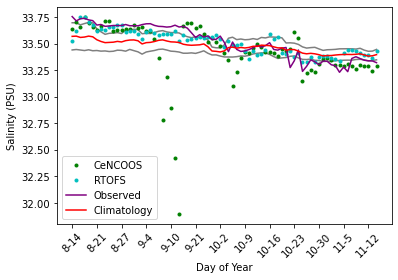

In [19]:
#plotting 2 Standard deviations from the climatology, RTOFS, CeNCOOS and observed data

plt.plot(salinity.index, salinity["2 SD +"],'r',color = 'tab:gray')
plt.plot(salinity.index, salinity["2 SD -"],'r',color = 'tab:gray')
plt.plot(salinity.index, salinity["CeNCOOS"],'g.',label = "CeNCOOS")
plt.plot(salinity.index, salinity["RTOFS"],'c.',label= "RTOFS")
plt.plot(salinity.index, salinity["Observed"],color="purple",label= "Observed")
plt.plot(salinity.index, salinity["Climatology"],'r',label= "Climatology")

plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Day of Year')
plt.ylabel('Salinity (PSU)')
my_xticks =  []

axis_seperation = 6
for x in range(0,len(salinity["month"])):
    date = str(salinity["month"][x])+ "-"+ str(salinity["day"][x])
    if x % axis_seperation == 0:
        my_xticks.append(date)

plt.xticks(salinity.index[::axis_seperation], my_xticks)
plt.show()

In [20]:
#checking to see if RTOFS and CeNCOOS is in bound of SEM Climatology

r_count = in_bounds(salinity["RTOFS"],salinity["2 SD +"],salinity["2 SD -"])

c_count = in_bounds(salinity["CeNCOOS"],salinity["2 SD +"],salinity["2 SD -"])

print("RTOFS Count: ",r_count)
print("CeNCOOS Count: ",c_count)

RTOFS Count:  48
CeNCOOS Count:  23


In [21]:
#now calculating model and observed difference from climatology data

salinity["CeNCOOS_Diff_Clim"]  = abs(salinity['CeNCOOS'] - salinity['Climatology'])
salinity["RTOFS_Diff_Clim"]  = abs(salinity['RTOFS'] - salinity['Climatology'])

salinity["CeNCOOS_Diff_Obs"] = abs(salinity['CeNCOOS'] - salinity['Observed'])
salinity["RTOFS_Diff_Obs"]   = abs(salinity['RTOFS'] - salinity['Observed'])

salinity["Obs_diff_Climatology"] = abs(salinity['Observed']- salinity['Climatology'])


salinity.head(5)



,day,month,Climatology,Salinity var,Salinity count,Standard Error,2 SD +,2 SD -,Observed,CeNCOOS,RTOFS,CeNCOOS_Diff_Clim,RTOFS_Diff_Clim,CeNCOOS_Diff_Obs,RTOFS_Diff_Obs,Obs_diff_Climatology
0,14,8,33.569776,0.036868,9,0.064004,33.697783,33.441769,33.756000,33.640703,33.529952,0.070927,0.039824,0.115297,0.226048,0.186224
1,15,8,33.571839,0.035615,9,0.062906,33.697651,33.446026,33.715375,33.705039,33.619848,0.133200,0.048009,0.010336,0.095527,0.143536
2,16,8,33.559626,0.031552,9,0.059210,33.678046,33.441206,33.735920,33.661183,33.755164,0.101558,0.195538,0.074737,0.019244,0.176294
3,17,8,33.563231,0.036382,9,0.063580,33.690390,33.436071,33.739250,33.749227,33.749753,0.185996,0.186522,0.009977,0.010503,0.176019
4,19,8,33.571937,0.037195,9,0.064286,33.700510,33.443364,33.724875,33.699739,33.708435,0.127802,0.136498,0.025136,0.016440,0.152938


In [22]:
#Seeing which model has a greater difference from the Climatology Models

salinity["Better Model"] = pairwise_comparison(salinity['RTOFS_Diff_Clim'],'R',salinity['CeNCOOS_Diff_Clim'],'C')

salinity.head(5)

,day,month,Climatology,Salinity var,Salinity count,Standard Error,2 SD +,2 SD -,Observed,CeNCOOS,RTOFS,CeNCOOS_Diff_Clim,RTOFS_Diff_Clim,CeNCOOS_Diff_Obs,RTOFS_Diff_Obs,Obs_diff_Climatology,Better Model
0,14,8,33.569776,0.036868,9,0.064004,33.697783,33.441769,33.756000,33.640703,33.529952,0.070927,0.039824,0.115297,0.226048,0.186224,R
1,15,8,33.571839,0.035615,9,0.062906,33.697651,33.446026,33.715375,33.705039,33.619848,0.133200,0.048009,0.010336,0.095527,0.143536,R
2,16,8,33.559626,0.031552,9,0.059210,33.678046,33.441206,33.735920,33.661183,33.755164,0.101558,0.195538,0.074737,0.019244,0.176294,C
3,17,8,33.563231,0.036382,9,0.063580,33.690390,33.436071,33.739250,33.749227,33.749753,0.185996,0.186522,0.009977,0.010503,0.176019,C
4,19,8,33.571937,0.037195,9,0.064286,33.700510,33.443364,33.724875,33.699739,33.708435,0.127802,0.136498,0.025136,0.016440,0.152938,C


In [23]:
for i in range(0,len(sources)):

    salinity[sources[i] + " Model Below Climatology"]= pairwise_comparison(salinity[sources[i]],sourcesabbv[i], salinity["Climatology"],"")

    salinity[sources[i] + " Model Above Climatology"]= pairwise_comparison(salinity[sources[i]],"",salinity["Climatology"],sourcesabbv[i])


for i in range(0,len(models)):
    salinity[models[i] + " Model Below Observation"]= pairwise_comparison(salinity[models[i]],modelabbv[i],salinity['Observed'],"")

    salinity[models[i] + " Model Above Observation"]= pairwise_comparison(salinity[models[i]],"",salinity['Observed'],modelabbv[i])


salinity.head(5)

,day,month,Climatology,Salinity var,Salinity count,Standard Error,2 SD +,2 SD -,Observed,CeNCOOS,...,RTOFS Model Below Climatology,RTOFS Model Above Climatology,CeNCOOS Model Below Climatology,CeNCOOS Model Above Climatology,Observed Model Below Climatology,Observed Model Above Climatology,RTOFS Model Below Observation,RTOFS Model Above Observation,CeNCOOS Model Below Observation,CeNCOOS Model Above Observation
0,14,8,33.569776,0.036868,9,0.064004,33.697783,33.441769,33.756000,33.640703,...,R,,,C,,O,R,,C,
1,15,8,33.571839,0.035615,9,0.062906,33.697651,33.446026,33.715375,33.705039,...,,R,,C,,O,R,,C,
2,16,8,33.559626,0.031552,9,0.059210,33.678046,33.441206,33.735920,33.661183,...,,R,,C,,O,,R,C,
3,17,8,33.563231,0.036382,9,0.063580,33.690390,33.436071,33.739250,33.749227,...,,R,,C,,O,,R,,C
4,19,8,33.571937,0.037195,9,0.064286,33.700510,33.443364,33.724875,33.699739,...,,R,,C,,O,R,,C,


In [24]:
#counting times observation was above or below climatology
counter = 0
for i in range(0,len(sources)):
  
    var_name[name[counter]] =  sum_1_column(salinity[sources[i]+ " Model Above Climatology"],sourcesabbv[i])
    print("Times "+ sources[i] + " Model was Above Climatology", var_name[name[counter]])
    counter +=1
    var_name[name[counter]] =  sum_1_column(salinity[sources[i]+ " Model Below Climatology"],sourcesabbv[i])
    print("Times "+ sources[i] + " Model was Below Climatology", var_name[name[counter]])
    counter +=1
    print(" ")

for i in range(0,len(models)):
    counter 
    var_name[name[counter]] =  sum_1_column(salinity[models[i]+ " Model Above Observation"],modelabbv[i])
    print("Times "+ models[i] + " Model was Above Observation", var_name[name[counter]])
    counter +=1 
    var_name[name[counter]] =  sum_1_column(salinity[models[i]+ " Model Below Observation"],modelabbv[i])
    print("Times "+ models[i] + " Model was Below Observation", var_name[name[counter]])
    counter +=1
    print(" ")

Times RTOFS Model was Above Climatology 53
Times RTOFS Model was Below Climatology 22
 
Times CeNCOOS Model was Above Climatology 35
Times CeNCOOS Model was Below Climatology 40
 
Times Observed Model was Above Climatology 43
Times Observed Model was Below Climatology 32
 
Times RTOFS Model was Above Observation 32
Times RTOFS Model was Below Observation 43
 
Times CeNCOOS Model was Above Observation 23
Times CeNCOOS Model was Below Observation 52
 


In [25]:
sum_cmatrix(salinity,"RTOFS Model Above Climatology","RTOFS Model Below Climatology","R","Observed Model Above Climatology","Observed Model Below Climatology","O")

true positive 39
true negative 18
false negative 4
false positive 14

Precision: 0.7358490566037735
Recall: 0.9069767441860465
Accuracy: 0.76
F1 Score: 0.8124999999999999


In [26]:
sum_cmatrix(salinity,"CeNCOOS Model Above Climatology","CeNCOOS Model Below Climatology","C","Observed Model Above Climatology","Observed Model Below Climatology","O")

true positive 33
true negative 30
false negative 10
false positive 2

Precision: 0.9428571428571428
Recall: 0.7674418604651163
Accuracy: 0.84
F1 Score: 0.8461538461538461
